# 0. Preparation

In [1]:
!pip3 install seaborn

import os
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import _pickle as cPickle
#from glob import glob
import seaborn
from IPython.display import display, HTML

from PIL import Image
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix


import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras import backend as K 


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


# 1. Acquiring the training data

## 1.1 Loading - splitting the data

In [2]:
import PIL
training_folder = './Training'
testing_folder = './Testing'
malignant_folder = './Training/malignant/'
benign_folder = './Training/benign/'

In [3]:
def load_images(load_dir, image_list):
    lst = [np.asarray(Image.open(load_dir + filename).convert('RGB')) for filename in image_list]
    return lst

def load_prepare_dataset(target_dir):
    benign_dir = target_dir + '/benign/'
    malignant_dir = target_dir + '/malignant/'
    #malignant = train_data.loc[(train_data['MEL'] == 1)| (train_data['BCC'] == 1)]
    #benign = train_data.loc[(train_data['MEL'] == 0) & (train_data['BCC'] == 0)]
    
    benign_img = os.listdir(benign_dir)
    malignant_img = os.listdir(malignant_dir)
    
    # Load in training pictures 
    benign_images = load_images(benign_dir, benign_img)
    malignant_images = load_images(malignant_dir, malignant_img)
    print(f'len malignant:{len(malignant_img)}')
    print(f'len benign:{len(benign_img)}')
    X_benign = np.array(benign_images, dtype='uint8')
    X_malignant = np.array(malignant_images, dtype='uint8')

    # Create labels
    y_benign = np.zeros(X_benign.shape[0])
    y_malignant = np.ones(X_malignant.shape[0])

    # Merge data 
    x = np.concatenate((X_benign, X_malignant), axis = 0)
    y = np.concatenate((y_benign, y_malignant), axis = 0)

    # Shuffle data
    s = np.arange(x.shape[0])
    np.random.shuffle(s)
    x = x[s]
    y = y[s]

    #y = to_categorical(y, num_classes= 2)
    x = x/255.

    return x, y
    

In [4]:
X_train, y_train = load_prepare_dataset(training_folder)
X_test, y_test = load_prepare_dataset(testing_folder)

len malignant:8059
len benign:7548
len malignant:140
len benign:840


# 2. Data visualisation and exploration (work in progress)

## 2.1 Data exploration

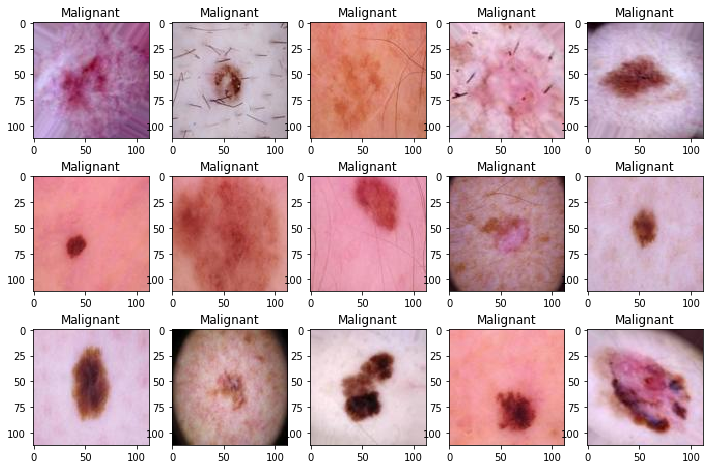

In [5]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if (y_train[i] == np.asarray([1,0])).all():
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

## 2.2 Data visualisation

In [18]:
#Missing graphs for presentation
# Summarise data
count_df = labels_df.iloc[::-1]

# Create annotations
annotations = [dict(
            y=count_df.loc[i,'Label'],
            x=count_df.loc[i,'Count'] + 1000,
            text=str(round(count_df.loc[i,'Count']/train_df.shape[0]*100,1))+'%',
            font=dict(
            size=14,
            color="#000000"
            ),
            bordercolor="#c7c7c7",
            borderwidth=1,
            borderpad=4,
            bgcolor="#ffffff",
            opacity=0.95,
            showarrow=False,
        ) for i in range(count_df.shape[0])]



fig = px.bar(labels_df,
             y = 'Label',
             x = 'Count',
             title       = 'Label Distribution',
             template    = 'plotly_dark',
             orientation = 'h',
             opacity     = 0.7,
             color       = 'Label',
             color_discrete_sequence = ['#38cae0','#d1324d'] 
            )


fig.update_layout(showlegend=False, annotations = annotations)
fig.show()
'''

'\n#Missing graphs for presentation\n# Summarise data\ncount_df = labels_df.iloc[::-1]\n\n# Create annotations\nannotations = [dict(\n            y=count_df.loc[i,\'Label\'],\n            x=count_df.loc[i,\'Count\'] + 1000,\n            text=str(round(count_df.loc[i,\'Count\']/train_df.shape[0]*100,1))+\'%\',\n            font=dict(\n            size=14,\n            color="#000000"\n            ),\n            bordercolor="#c7c7c7",\n            borderwidth=1,\n            borderpad=4,\n            bgcolor="#ffffff",\n            opacity=0.95,\n            showarrow=False,\n        ) for i in range(count_df.shape[0])]\n\n\n\nfig = px.bar(labels_df,\n             y = \'Label\',\n             x = \'Count\',\n             title       = \'Label Distribution\',\n             template    = \'plotly_dark\',\n             orientation = \'h\',\n             opacity     = 0.7,\n             color       = \'Label\',\n             color_discrete_sequence = [\'#38cae0\',\'#d1324d\'] \n            

# 3. Building the models 
## 3.1 Necessary functions

In [6]:
def plot_confusion_matrix(y_predicted, y_true):
    cm = confusion_matrix(y_true, y_predicted)
    plt.figure(figsize=(8,6))
    seaborn.heatmap(cm,annot=True, fmt='.20g')
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    
def plot_perf_metrics(y_true, y_predicted):
    cr = pd.DataFrame(classification_report(y_true, y_predicted, output_dict = True))
    cr.transpose().sort_values(by = ['f1-score'], ascending = False)
    cr = cr.round(2)
    display(HTML(cr.to_html()))

def eval_plot(y_true, y_predicted):
    plot_confusion_matrix(y_true, y_predicted)
    plot_perf_metrics(y_true, y_predicted)
    

def plot_roc_curve (y_true, y_predicted, label):
    fpr, tpr, thresholds = roc_curve(y_true, y_predicted)
    plt.figure(0)
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--') 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()

In [33]:
def eval_plot_model(model):
    model.compile(optimizer = 'Adam' ,loss = "binary_crossentropy", metrics=['AUC'])
    history = model.fit(X_train, y_train, validation_split=0.2,
                        epochs= epochs, batch_size= batch_size, verbose=1, 
                        callbacks=[learning_rate_reduction])

    
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('model AUC')
    plt.ylabel('AUC')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    #pd.DataFrame(history.history).plot(figsize=(8,5))
    
    y_pred = model.predict(X_test) 

    print(accuracy_score(y_test, y_pred.round()))

    eval_plot(y_test, y_pred.round())
    plot_roc_curve(y_test, y_pred, None)

In [8]:
def build_cnn(input_shape= (112,112,3), lr = 1e-3, num_classes= 2, init= 'normal'):
    
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape, activation= 'relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape, activation= 'relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape, activation= 'relu', kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer=init))
    model.add(Dense(256, activation='relu', kernel_initializer=init))

    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["AUC"])
    return model


In [9]:
def save_model(model, model_filename):
    model_json = model.to_json()

    with open(model_filename + ".json", "w") as json_file:
        json_file.write(model_json)
        
    model.save_weights(model_filename + ".h5")
    print("Saved")

    del model
    K.clear_session()

## 3.2 Custom CNN

### 3.2.1 Initialising model parameters

In [25]:
input_shape = (112,112,3)
lr = 1e-4
init = 'normal'
epochs = 30
batch_size = 512

learning_rate_reduction = ReduceLROnPlateau(monitor='val_auc', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

### 3.1.2 Cross-validation

In [ ]:
kfold = KFold(n_splits=3, shuffle=True, random_state=17)

cvscores = []
for train, test in kfold.split(X_train, y_train):
    model = build_cnn(lr=lr, 
                  init= init, 
                  input_shape= input_shape)
    
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=1)
    scores = model.evaluate(X_train[test], y_train[test], verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

### 3.1.3 Testing

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 64)      

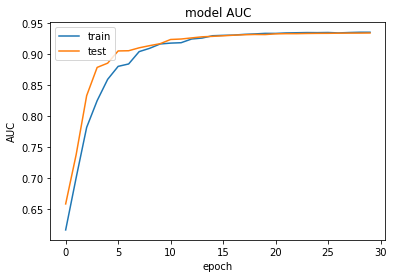

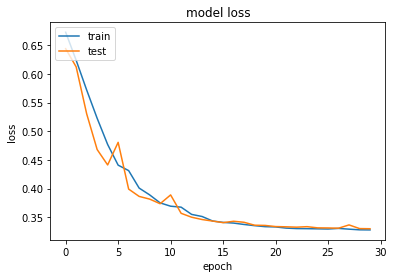

0.8


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.89,0.32,0.8,0.61,0.81
recall,0.87,0.36,0.8,0.62,0.80
f1-score,0.88,0.34,0.8,0.61,0.80
support,840.00,140.00,0.8,980.00,980.00


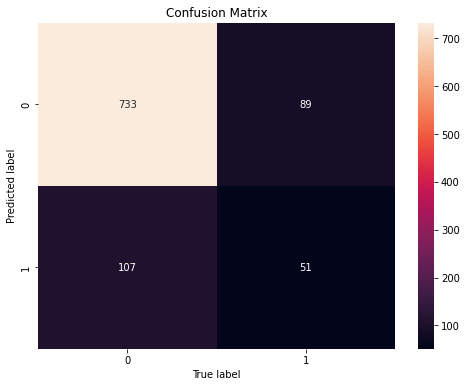

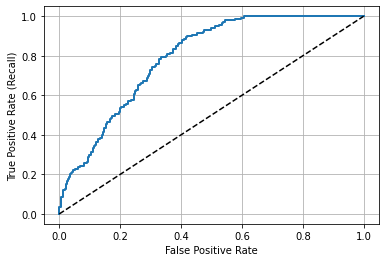

In [26]:
cnn_model = build_cnn(lr=lr, init= init, input_shape= input_shape)

eval_plot_model(cnn_model)

## 3.2 ResNet50
### 3.2.1 Building the model

In [34]:
epochs = 10

resnet50_model = ResNet50(include_top=False,
                 weights= 'imagenet',
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

for layer in resnet50_model.layers:
    layer.trainable = False
    
renet_model = Sequential()
renet_model.add(resnet50_model)
renet_model.add(Flatten())
renet_model.add(Dense(512, activation = 'relu'))
renet_model.add(Dropout(0.25))
renet_model.add(Dense(1, activation='sigmoid'))

### 3.2.2 Testing

Epoch 1/10
25/25 [==============================] - 12s 356ms/step - loss: 0.7891 - auc: 0.5241 - val_loss: 0.6740 - val_auc: 0.8244 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - 7s 268ms/step - loss: 0.6555 - auc: 0.6658 - val_loss: 0.6283 - val_auc: 0.8186 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - 8s 320ms/step - loss: 0.6139 - auc: 0.7757 - val_loss: 0.5993 - val_auc: 0.8215 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - 7s 269ms/step - loss: 0.5843 - auc: 0.8009 - val_loss: 0.5669 - val_auc: 0.8267 - lr: 0.0010
Epoch 5/10
25/25 [==============================] - 8s 319ms/step - loss: 0.5608 - auc: 0.8114 - val_loss: 0.5581 - val_auc: 0.8319 - lr: 0.0010
Epoch 6/10
25/25 [==============================] - 7s 268ms/step - loss: 0.5502 - auc: 0.8047 - val_loss: 0.5508 - val_auc: 0.8367 - lr: 0.0010
Epoch 7/10
25/25 [==============================] - ETA: 0s - loss: 0.5332 - auc: 0.8188
Epoch 00007: ReduceLROnPlateau reducing 

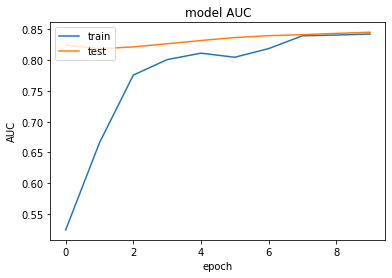

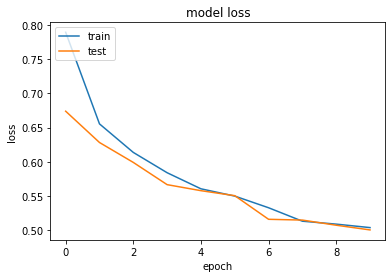

0.7724489795918368


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.90,0.30,0.77,0.60,0.81
recall,0.83,0.43,0.77,0.63,0.77
f1-score,0.86,0.35,0.77,0.61,0.79
support,840.00,140.00,0.77,980.00,980.00


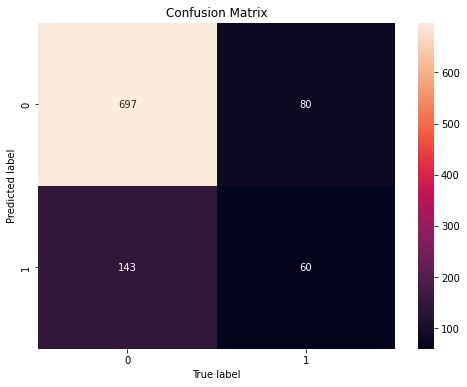

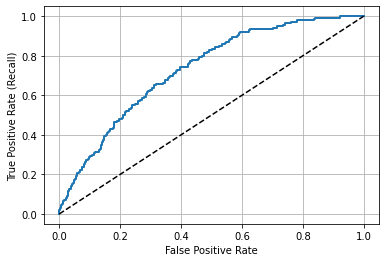

In [28]:
eval_plot_model(renet_model)

## 3.3 VGG19

### 3.2.2 Building the model

In [35]:
epochs = 10

vgg19_model = VGG19(include_top=False,
                 weights= 'imagenet',
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

for layer in vgg19_model.layers:
    layer.trainable = False
    
vgg_model = Sequential()
vgg_model.add(vgg19_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.25))
vgg_model.add(Dense(1, activation='sigmoid'))

### 3.2.2 Testing

Epoch 1/10
25/25 [==============================] - 14s 466ms/step - loss: 0.5182 - auc: 0.8278 - val_loss: 0.4270 - val_auc: 0.8863 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - 9s 356ms/step - loss: 0.4167 - auc: 0.8911 - val_loss: 0.4072 - val_auc: 0.9002 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - 9s 358ms/step - loss: 0.3895 - auc: 0.9061 - val_loss: 0.3836 - val_auc: 0.9094 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - 9s 358ms/step - loss: 0.3726 - auc: 0.9144 - val_loss: 0.3696 - val_auc: 0.9155 - lr: 0.0010
Epoch 5/10
25/25 [==============================] - 9s 362ms/step - loss: 0.3612 - auc: 0.9198 - val_loss: 0.3658 - val_auc: 0.9198 - lr: 0.0010
Epoch 6/10
25/25 [==============================] - ETA: 0s - loss: 0.3521 - auc: 0.9238
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 [==============================] - 9s 365ms/step - loss: 0.3521 - auc: 0.9238 - val_loss: 0.3539 - 

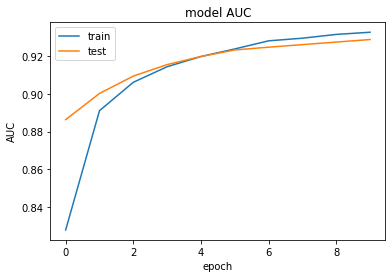

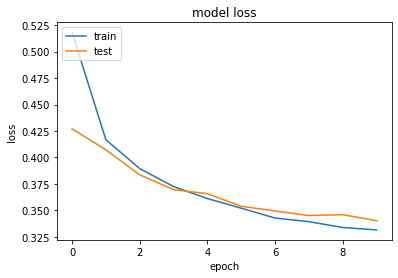

0.8163265306122449


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.90,0.38,0.82,0.64,0.83
recall,0.88,0.43,0.82,0.65,0.82
f1-score,0.89,0.40,0.82,0.65,0.82
support,840.00,140.00,0.82,980.00,980.00


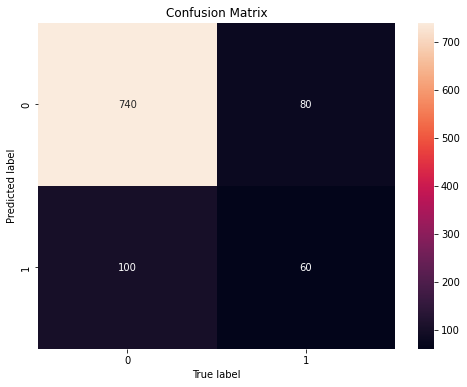

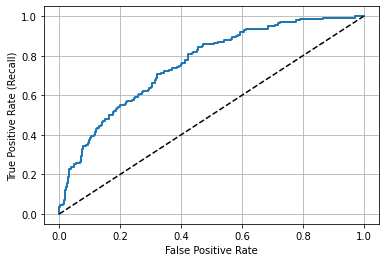

In [36]:
eval_plot_model(vgg_model)

In [ ]:
#save_model(model, 'cnn_model')
#save_model(renet_model, 'resnet')
#save_model(vgg_model, 'vgg')